# 迷路と箱入り娘

In [1]:
%matplotlib inline
import pylab as pl
import numpy as np
from search import breadth_first_search
import io
from IPython.display import display_png

## 迷路

次の迷路解てみたいです。

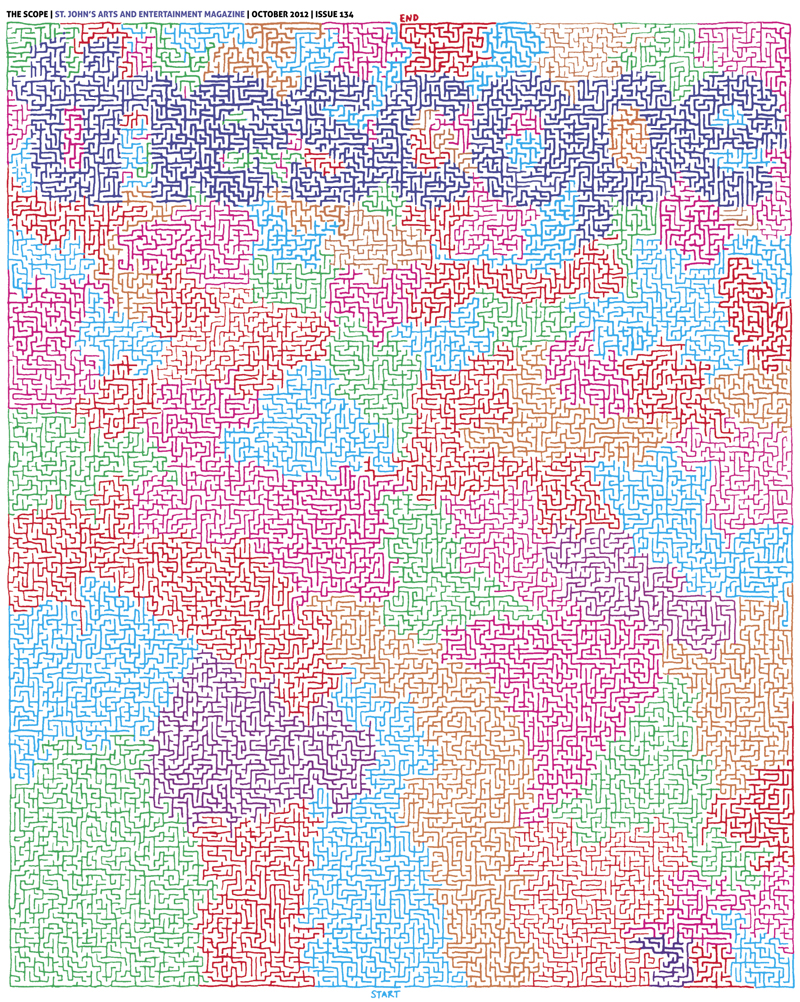

In [5]:
def show_image(img):
    f = io.BytesIO()
    pl.imsave(f, img, format="png")
    display_png(f.getvalue(), raw=True)

img = pl.imread("data/maze.png")
sx, sy = (402, 986)
ex, ey = (398,  25)
bimg = np.all(img > 0.81, axis=2)
H, W = bimg.shape

x0, x1 = np.where(bimg[H//2, :]==0)[0][[0, -1]]
bimg[H//2, :x0] = 0
bimg[H//2, x1:] = 0

show_image(img)

幅優先探索で迷路を解けます。次は汎用幅優先探索の関数です。

In [ ]:
from collections import deque

def flat_path(status):
    path = []
    while True:
        path.append(status[0])
        status = status[1]
        if status is None:
            break
    return path[::-1]

def breadth_first_search(start_node, edges, is_solved):
    todo = deque([(start_node, None)])
    checked = set([start_node])

    while todo:
        status = todo.popleft()
        node = status[0]
        if is_solved(node):
            return flat_path(status)

        for next_node in edges[node]:
            if next_node not in checked:
                todo.append((next_node, status))
                checked.add(next_node)

まずすべての隣接白いピクセルを計算します。

In [22]:
from collections import defaultdict

mask = (bimg[1:, :] & bimg[:-1, :]) 
idx = np.where(mask.ravel())[0]
vedge = np.c_[idx, idx + W]

mask = (bimg[:, 1:] & bimg[:, :-1])
y, x = np.where(mask)
idx = y * W + x
hedge = np.c_[idx, idx + 1]
edges = np.vstack([vedge, hedge])
edges.shape

(815878, 2)

幅優先探索で迷路を解てみます。

In [25]:
def show_solved_maze(img, shortest_path):
    path_x, path_y = shortest_path % W, shortest_path // W
    img_res = img.copy()
    img_res[path_y, path_x, :] = 0

    show_image(img_res)

In [28]:
%%time

node_edges = defaultdict(list)
for n1, n2 in edges.tolist():
    node_edges[n1].append(n2)
    node_edges[n2].append(n1)

startid = sy * W + sx
endid   = ey * W + ex

shortest_path = np.array(breadth_first_search(startid, node_edges, lambda x: x == endid))   

Wall time: 2.22 s


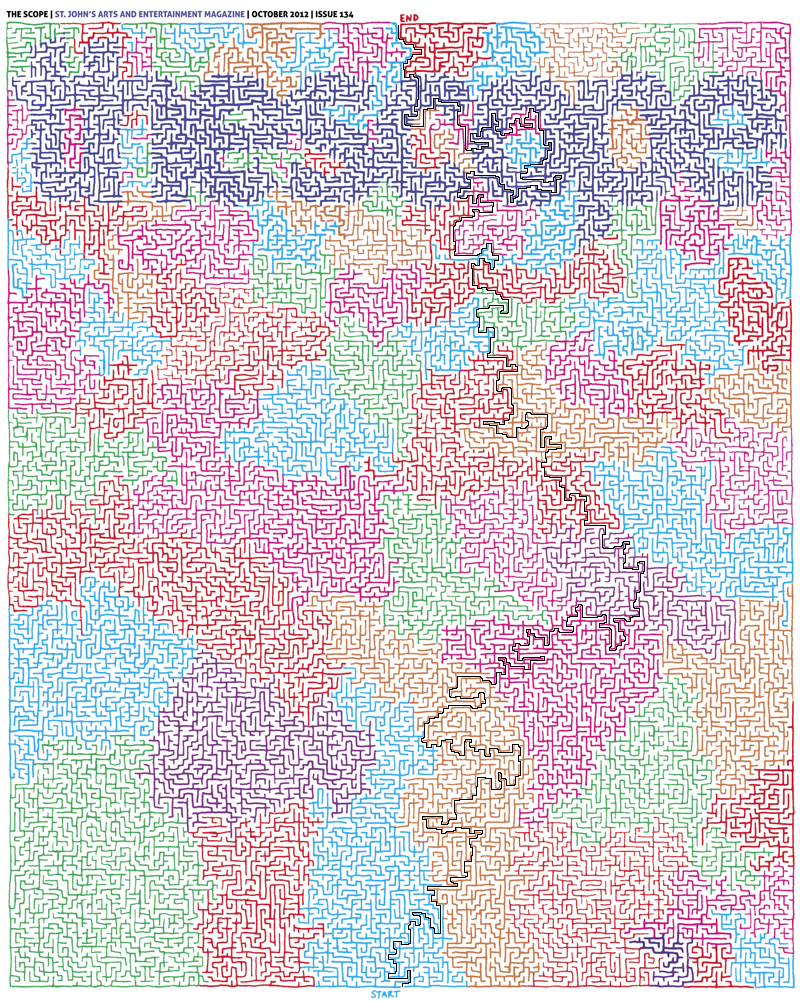

In [29]:
show_solved_maze(img, shortest_path)

グラフライブラリ`igraph`を使えば、早くになります。

In [30]:
%%time
import igraph
g = igraph.Graph()
g.add_vertices(np.product(bimg.shape))
g.add_edges(edges)

shortest_path = np.array(g.get_shortest_paths(startid, endid, mode=igraph.OUT))

Wall time: 611 ms


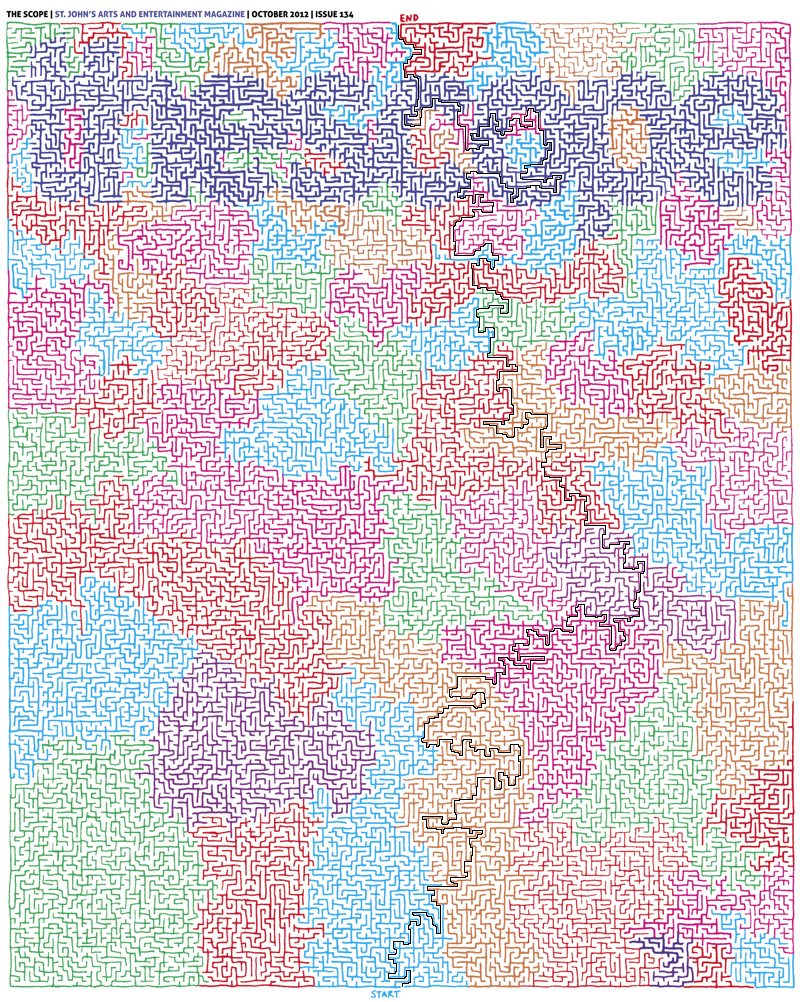

In [31]:
show_solved_maze(img, shortest_path)

## 箱入り娘 (パズル)

![](https://upload.wikimedia.org/wikipedia/ja/1/16/Hakoiri3.JPG)

In [32]:
import json
import random
import bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokehelp import show_figure_with_callback
from hrd import status_to_positions, HrdSolver, to_rect
output_notebook()

Loading BokehJS ...

この問題も幅優先探索で解けます。詳細は`hrd.py`に参考してください。次の`plot_hrd_solve_steps()`は解を動画に変換します。

In [41]:
from hrd import HrdSolver

def plot_hrd_solve_steps(start_status):
    solver = HrdSolver()
    rects, moves = solver.get_bokeh_data(start_status)
    
    source = ColumnDataSource(data=rects)

    def animation(source, moves):
        step_count = 10
        tid = -1
        step = 0
        idx = 0
        data = source.get('data')
        console.log(data)
        init_x = data.x[:]
        init_y = data.y[:]

        def stop_timer():
            nonlocal tid
            if tid != -1:
                window.clearInterval(tid)
                tid = -1

        def start_timer():
            nonlocal tid
            tid = window.setInterval(callback, 10)

        def callback():
            nonlocal idx, step
            i, x1, y1, x2, y2 = moves[idx]
            k = step / (step_count - 1.0)
            x = x1 + (x2 - x1) * k
            y = y1 + (y2 - y1) * k
            data.x[i] = x
            data.y[i] = y
            source.trigger("change")

            step += 1
            if step == step_count:
                idx += 1        
                step = 0
            if idx == len(moves):
                stop_timer()

        def reset(evt):
            nonlocal idx, step
            idx = step = 0
            for i in range(len(init_x)):
                data.x[i] = init_x[i]
                data.y[i] = init_y[i]
            source.trigger("change")
            stop_timer()
            window.setTimeout(start_timer, 1000)

        fig["$el"].click(reset)
        start_timer()

    f = figure(plot_width=250, plot_height=250, toolbar_location=None, 
               x_axis_type=None, y_axis_type=None, 
               x_range=(-1, 5), y_range=(-1, 5))
    f.rect("x", "y", "w", "h", fill_color="c", source=source)
    show_figure_with_callback(f, animation, source=source, moves=json.dumps(moves))

In [43]:
from hrd import dump_graph
dump_graph("ABBBBCDDDD")

C:\Users\RY\Documents\notebooks\intro-python\ABBBBCDDDD.pickle saved


In [44]:
plot_hrd_solve_steps('BAABBAABBCCBBDDBD  D')